# Cancer de mama - Regresión logistica
### Mauricio Tumalan Castillo - A01369288
### Tecnológico de Monterrey - TC3006C.101

En este proyecto, se utilizará la regresión logistica para clasificar datos obtenidos relacionados al cancer de mama. Se utilizarán implementaciones manuales tanto Sigmoidal como ReLU, así como implementación con la librería de Sci-kit Learn, comparando resultados obtenidos.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import os
import codecs
from operator import itemgetter
from statistics import mode
import random
import math

# NumPy y Pandas para manipulación de datos
# Scikit-learn para implementar el algoritmo de regresión logística y evaluar el modelo
# Matplotlib para visualización de datos
# os y codecs para leer los archivos de texto
# itemgetter para obtener el elemento más común en una lista
# mode para obtener la moda de una lista  

El conjunto de datos contiene 699 datos, de los cuales 599 de entrenamiento y 100 para pruebas. Existiendo los siguientes atributos:

1. Clump Thickness (1.0 - 10.0)
2. Uniformity of Cell Size (1.0 - 10.0)
3. Uniformity of Cell Shape (1.0 - 10.0)
4. Marginal Adhesion (1.0 - 10.0)
5. Single Epithelial Cell Size (1.0 - 10.0)
6. Bare Nuclei (1.0 - 10.0)
7. Bland Chromatin (1.0 - 10.0)
8. Normal Nucleoli (1.0 - 10.0)
9. Mitoses (1.0 - 10.0)
10. Class: (clasificadora, benign or malignant)

In [3]:
# Cargar los datos de entrenamiento
current_path = os.getcwd()
training_data = os.path.join(current_path, 'Datos-2/cancerTraining.txt')
test_data = os.path.join(current_path, 'Datos-2/cancerTest.txt')

In [4]:
# Inicializar las listas de datos y etiquetas
training = []
trainingLabels = []
test = []
testLabels = []

In [5]:
# Leer los datos de entrenamiento y test desde los archivos de texto, almacenarlos en las listas correspondientes
with codecs.open(training_data, 'r', 'utf-8') as file:
    for line in file:
        line = line.strip().split(',')
        training.append([float(x) for x in line[:-1]])
        if line[-1] == 'benign':
            trainingLabels.append(1)
        else:
            trainingLabels.append(0)

with codecs.open(test_data, 'r', 'utf-8') as file:
    for line in file:
        line = line.strip().split(',')
        test.append([float(x) for x in line[:-1]])
        if line[-1] == 'benign':
            testLabels.append(1)
        else:
            testLabels.append(0)

Las siguientes funciones fungen como funciones de activación, siendo la sigmoidal y ReLU, en la sigmoidal agregamos un clip para evitar el overflow de los datos.

In [6]:
def sigmoid(z):
    z = np.clip(z, -500, 500) # Evita overflow de datos
    return 1 / (1 + np.exp(-z)) # Función de activación Sigmoidal

def relu(x):
    return np.maximum(0, x) # Función de activación ReLU

En el siguiente bloque de código se implemente el algoritmo de ascenso de gradiente estocástico para ajustar un conjunto de pesos de forma manual. El objetivo es minimizar el error entre las predicciones del modelo y las etiquetas reales de los datos de entrenamiento.

In [7]:
def gradient(sampleList, weights, activation):
    sumElements=0.0
    for x,y in zip(sampleList,weights):
        sumElements=sumElements+(x*y)
    if activation == 'sigmoid':
        return sigmoid(sumElements)
    if activation == 'relu':
        return relu(sumElements)

def stochasticGradientAscent(trainingLists, trainingLabels, featureNumber, activation, adalpha, iterations=150):
    sampleNumber = len(trainingLists)
    weights = [1.0] * featureNumber
    results = []

    for x in range(1, iterations + 1):
        sampleIndex = list(range(sampleNumber))
        for y in range(sampleNumber):
            alpha = 4 / (1.0 + x + y) + adalpha

            randIndex = int(random.uniform(0, len(sampleIndex)))
            sampleGradient = gradient(trainingLists[randIndex], weights, activation)
            error = trainingLabels[randIndex] - sampleGradient

            temp = [alpha * (error * trainingLists[randIndex][index]) for index in range(featureNumber)]
            weights = [weights[z] + temp[z] for z in range(featureNumber)]
            del sampleIndex[randIndex]

        # Calculate metrics at each iteration
        predictions = [classifyList(test_list, weights, activation) for test_list in trainingLists]
        accuracy = accuracy_score(trainingLabels, predictions)
        precision = precision_score(trainingLabels, predictions, zero_division=0)
        recall = recall_score(trainingLabels, predictions)
        conf_matrix = confusion_matrix(trainingLabels, predictions)

        # Store the results for each iteration
        results.append({
            "iteration": x,
            "alpha": adalpha,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "confusion_matrix": conf_matrix,
            "weights": weights.copy()
        })

    return weights, results

def classifyList(testList, weights, activation):
    sumElements=0
    for x,y in zip(testList,weights):
        sumElements=sumElements+(x*y)
    if activation == 'sigmoid':
        probability = sigmoid(sumElements)
    if activation == 'relu':
        probability = relu(sumElements)
    if probability > 0.5:
        return 1.0
    else:
        return 0.0

El siguiente bloque de código es la implementación manual de esta gradiente estocástico para clasificar mediante la regresión lineal con las funciones de activación sigmoid y ReLU. Se varía la tasa de aprendizaje ('alpha') de 0.01 a 0.3 y se mide el impacto en la precisión del modelo.

In [8]:
featureNumber = len(training[0])

# Initialize result containers
results_sigmoid = []
results_relu = []

# Range of alpha values
alpha_values = [alpha for alpha in np.arange(0.01, 0.31, 0.01)]

for alpha in alpha_values:
    # Sigmoid activation
    optimalWeights, training_results_sigmoid = stochasticGradientAscent(training, trainingLabels, featureNumber, 'sigmoid', alpha, 150)
    correct_sigmoid = sum(classifyList(test[x], optimalWeights, "sigmoid") == testLabels[x] for x in range(len(test)))
    accuracy_sigmoid = correct_sigmoid / len(test)
    results_sigmoid.append({
        'alpha': alpha,
        'accuracy': accuracy_sigmoid,
        'weights': optimalWeights,
        'details': training_results_sigmoid
    })

    # ReLU activation
    optimalWeights, training_results_relu = stochasticGradientAscent(training, trainingLabels, featureNumber, 'relu', alpha, 150)
    correct_relu = sum(classifyList(test[x], optimalWeights, "relu") == testLabels[x] for x in range(len(test)))
    accuracy_relu = correct_relu / len(test)
    results_relu.append({
        'alpha': alpha,
        'accuracy': accuracy_relu,
        'weights': optimalWeights,
        'details': training_results_relu
    })


La implementación de Scikit-learn es la siguiente

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import plotly.express as px

# Create the logistic regression model
model = LogisticRegression()
model.fit(training, trainingLabels)

# Predict the test data
predictions = model.predict(test)
precision_tan = 0
for i in range(len(testLabels)):
    if predictions[i] == testLabels[i]:
        precision_tan += 1

De igual forma, se ejecutan las formas manuales de PlotLy

In [17]:
import plotly.express as px
import pandas as pd

# Prepare the data for Plotly
data = {
    'Alpha': [],
    'Accuracy': [],
    'Activation': []
}

for result in results_sigmoid:
    data['Alpha'].append(result['alpha'])
    data['Accuracy'].append(result['accuracy'])
    data['Activation'].append('Sigmoid')

for result in results_relu:
    data['Alpha'].append(result['alpha'])
    data['Accuracy'].append(result['accuracy'])
    data['Activation'].append('ReLU')


Ya con las siguientes implementaciones podemos observar las matrices de confusión, con las que se puede ver las precisiones de los modelos.

In [12]:
cm = confusion_matrix(testLabels, predictions)
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=['Malignant', 'Benign'], y=['Malignant', 'Benign'])
fig.show()

In [15]:
#Confussion matrix for sigmoid
best_sigmoid = max(results_sigmoid, key=itemgetter('accuracy'))
conf_matrix_sigmoid = best_sigmoid['details'][-1]['confusion_matrix']
fig = px.imshow(conf_matrix_sigmoid, labels=dict(x="Predicted", y="True", color="Count"), x=['Malignant', 'Benign'], y=['Malignant', 'Benign'])
fig.show()

In [16]:
#Confussion matrix for relu
best_relu = max(results_relu, key=itemgetter('accuracy'))
conf_matrix_relu = best_relu['details'][-1]['confusion_matrix']
fig = px.imshow(conf_matrix_relu, labels=dict(x="Predicted", y="True", color="Count"), x=['Malignant', 'Benign'], y=['Malignant', 'Benign'])
fig.show()

Al iterar entre 3 y 150, así como cambiando el alpha en un rango de 0.01 a 0.3 obtenemos la siguiente gráfica

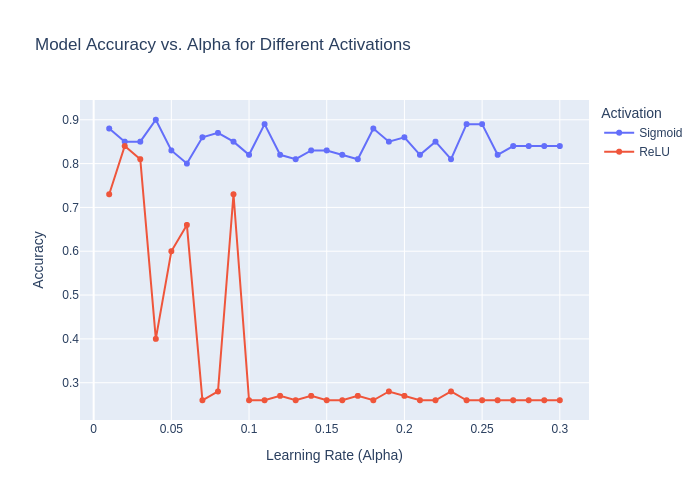

In [14]:
df = pd.DataFrame(data)

# Create the plot
fig = px.line(df, x='Alpha', y='Accuracy', color='Activation', 
              title='Model Accuracy vs. Alpha for Different Activations',
              labels={'Alpha': 'Learning Rate (Alpha)', 'Accuracy': 'Accuracy'},
              markers=True)

# Show the plot
fig.show(renderer="png")

Tras realizar esta graficación, podemos concluir que con la función de activación sigmoidal se obtienen resultados más consistentes, a comparación de la implementación con la ReLU.